Some notes on downsampling data for display
=======================

The smaller the time step of a simulation, the more accurate it is. Empirically, for the Euler method, it looks like 0.001 JD per step (or about a minute) is decent for our purposes. This means that we now have 365.25 / 0.001 = {{365.25 / 0.001}} points per simulation object, or {{12 * 365.25 / 0.001}} bytes. However, we don't really need such dense points for display. On the other hand, 4MB is not that much and we could probably let it go, but just for fun let's explore some different downsampling schemes.

_Note: We can do both adaptive time steps for the simulation as well as use a better intergrator/gravity model to get by with larger time steps, but I haven't explored this yet as it requires a deeper understanding of such models and my intuition is that it still won't downsample the points to the extent that we want, not to mention being more complicated to program. We'll leave that for version 2.0 of the simulator._


We'll set up a simple simulation with the aim of generating some interesting trajectories. The main property we are looking for are paths that have different curvatures as we expect in simulations we will do - since spacecraft will engage/disengage engines and change attitude. 

In [1]:
import numpy as np
import numpy.linalg as ln
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Body:
    def __init__(self, _mass, _pos, _vel):
        self.mass = _mass
        self.pos = _pos
        self.vel = _vel
        self.acc = np.zeros(3)
    
    def setup_sim(self, steps=1000):
        self.trace = np.empty((steps, 3), dtype=float)
    
    def update(self, dt, n):
        self.pos += self.vel * dt
        self.vel += self.acc * dt
        self.acc = np.zeros(3)
        self.trace[n, :] = self.pos
        
    def plot_xy(self, ax):
        ax.plot(self.trace[:, 0], self.trace[:, 1])
        
def acc_ab(a, b):
    r = a.pos - b.pos
    r2 = np.dot(r, r)
    d = r / ln.norm(r)
    Fb = d * (a.mass * b.mass) / r2
    Fa = -Fb
    a.acc += Fa / a.mass
    b.acc += Fb / b.mass
    
        
def sim_step(bodies, dt, n):
    for n1, b1 in enumerate(bodies):
        for b2 in bodies[n1 + 1:]:
            acc_ab(b1, b2)
    
    for b1 in bodies:
        b1.update(dt, n)

    
def run_sim(bodies, steps, dt):
    for b in bodies:
        b.setup_sim(steps)
    for n in range(steps):
        sim_step(bodies, dt, n)

In [3]:
bodyA = Body(100, np.array([0.0, 1.0, 0.0]), np.array([0.0, -10.0, 0.0]))
bodyB = Body(100, np.array([0.0, -1.0, 0.0]), np.array([10.0, 0.0, 0.0]))
bodyC = Body(100, np.array([1.0, 0.0, 0.0]), np.array([0.0, 10.0, 0.0]))

N = 100000
dt = 1e-5

run_sim([bodyA, bodyB, bodyC], N, dt)

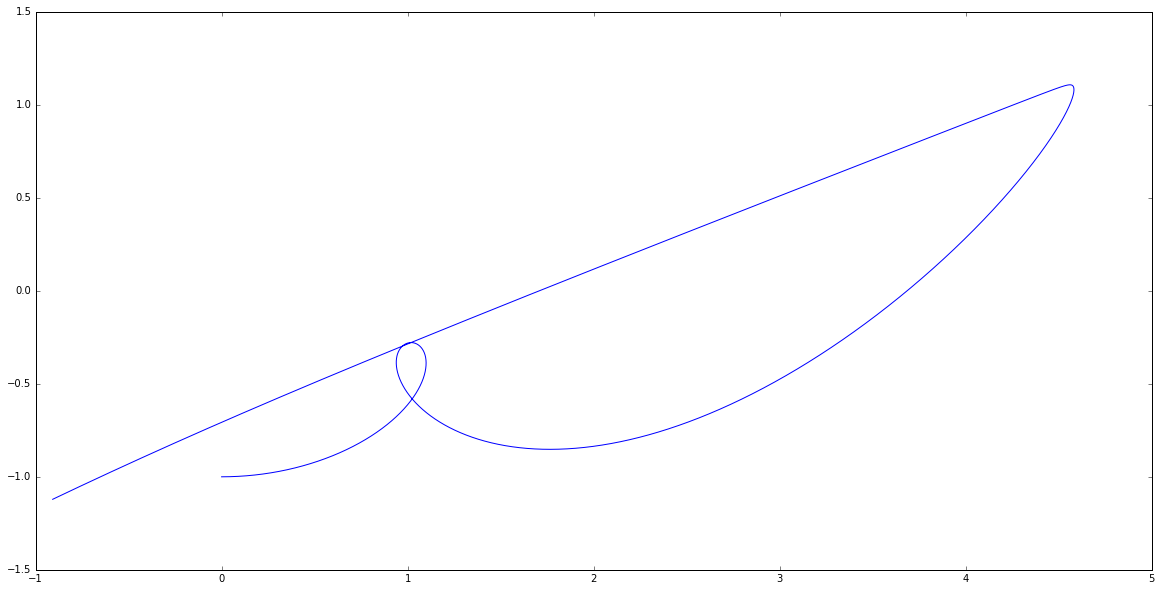

In [4]:
plt.figure(figsize=(20,10))
ax = plt.gca()
#bodyA.plot_xy(ax)
bodyB.plot_xy(ax)
#bodyC.plot_xy(ax)
_ = plt.axis('scaled')

Simple decimation
----------------
Let us try a simple decimation type downsampler, taking every Nth point of the simulation

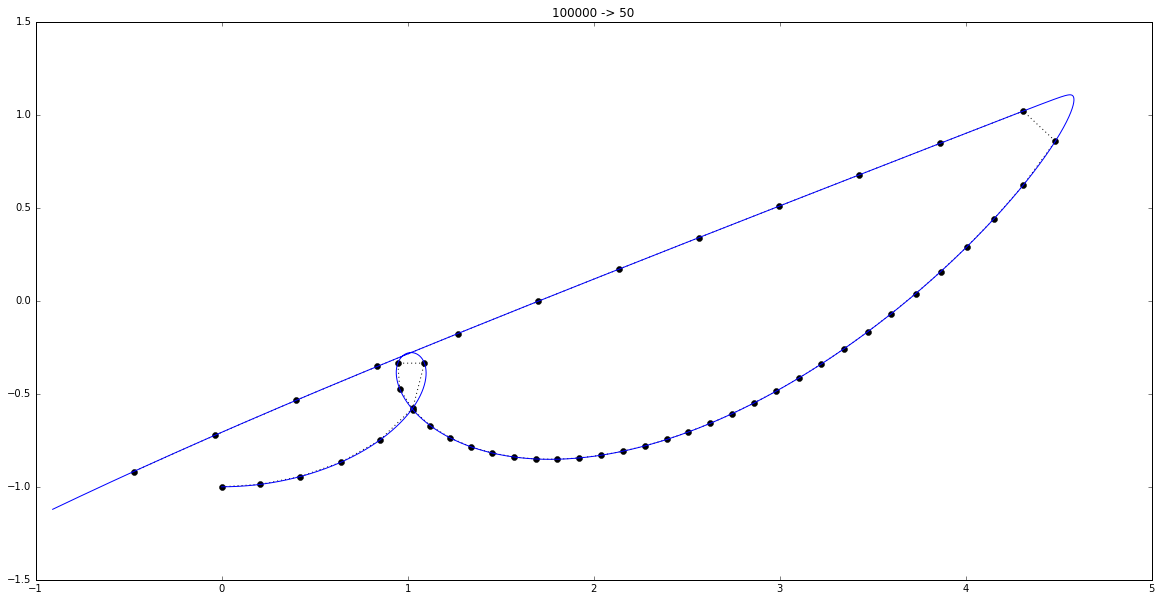

In [5]:
def downsample_decimate(body, every=20):
    return body.trace[::every, :]

decimated_trace = downsample_decimate(bodyB, every=2000)


def plot_compare(body, downsampled_trace):
    ds = downsampled_trace
    plt.figure(figsize=(20,10))
    plt.plot(ds[:, 0], ds[:, 1], 'ko:')
    ax = plt.gca()
    body.plot_xy(ax)
    plt.title('{} -> {}'.format(body.trace.shape[0], ds.shape[0]))
    _ = plt.axis('scaled')
    

plot_compare(bodyB, decimated_trace)

This is unsatisfactory because we are doing **poorly on the loop the loops.** It does not adapt itself to different curvatures. So we either have to have a lot of points when we don't need it - on the straight stretches, or have too few points on the tight curves. Can we do better?


Saturating maximum deviation
--------------------------

This scheme looks at the maximum deviation between the actual trace and the linear-interpolation between the points and adaptively downsamples to keep that deviation under a given threashold. 

In [6]:
def perp_dist(x, y, z):
    """x, z are endpoints, y is a point on the curve"""
    a = y - x
    a2 = np.dot(a, a)
    b = y - z
    b2 = np.dot(b, b)
    l = z - x
    l2 = np.dot(l, l)
    l = l2**0.5
    return (a2 - ((l2 + a2 - b2)/(2*l))**2)**0.5

# # Here we'll compute the value for each point, but using just the mid point is probably 
# # a pretty good heurstic
# def max_dist(pos, n0, n1):
#     return np.array([perp_dist(pos[n0, :], pos[n2, :], pos[n1, :]) for n2 in range(n0, n1)]).max()

# Here we'll just use the midpoint for speed
def mid_dist(pos, n0, n1):
    return perp_dist(pos[n0, :], pos[int((n1 + n0)/2), :], pos[n1, :])
    

def max_deviation_downsampler(pos, thresh=0.1):
    adaptive_pos = [pos[0, :]]
    last_n = 0
    for n in range(1, pos.shape[0]):
        #print(pos[last_n,:])
        if n == last_n: continue
        #print(pos[n, :])
        if mid_dist(pos, last_n, n) > thresh:
            adaptive_pos.append(pos[n - 1, :])
            last_n = n - 1
    return np.vstack(adaptive_pos)


max_dev_trace = max_deviation_downsampler(bodyB.trace, thresh=0.005)

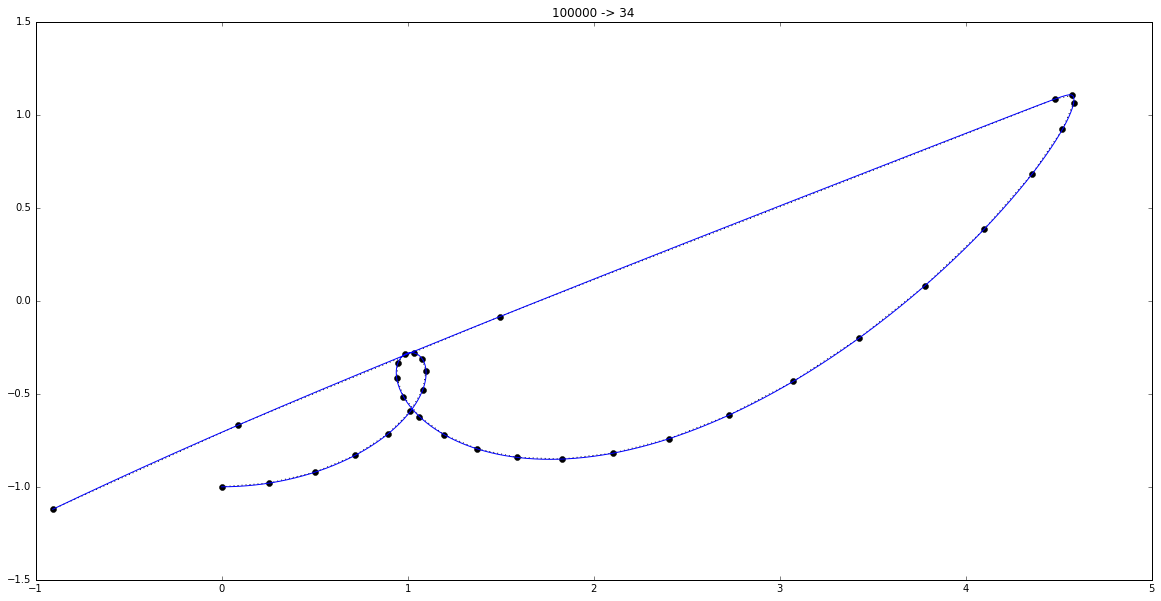

In [7]:
plot_compare(bodyB, max_dev_trace)

Hey, this is pretty good! One thing that bothers me about this scheme is that it requires memory. It's hidden in how I did the simulation here in the prototype, but we have to keep storing every point during the simulation in a temporary buffer until we can select a point for the ouput trace. **Can we come up with a scheme that is memory less?**


Fractal downsampling
-------------------
Ok, I call this frcatal downsampling because I was inspired by the notion of fractals where the length of a line depends on the scale of measurement. It's possibly more accurately described as length difference threshold downsampling, and that's no fun to say.

In this scheme I keep a running to total of the length of the original trace since the last sampled point and compare it to the length of the straight line segment if we use the current point as the next sampled point. If the ratio between the original length and the downsampled length goes above a given threshold, we use that as the next sampled point.

This discards the requirement for a (potentially very large) scratch buffer, but is it any good?

In [8]:
def fractal_downsampler(pos, ratio_thresh=2.0):
    d = np.diff(pos, axis=0)
    adaptive_pos = [pos[0, :]]
    last_n = 0
    for n in range(1, pos.shape[0]):
        if n == last_n: continue
        line_d = ln.norm(pos[n, :] - pos[last_n, :])
        curve_d = ln.norm(d[last_n:n,:], axis=1).sum()
        if curve_d / line_d  > ratio_thresh:
            adaptive_pos.append(pos[n - 1, :])
            last_n = n - 1
    adaptive_pos.append(pos[-1, :])
    return np.vstack(adaptive_pos)


fractal_trace = fractal_downsampler(bodyB.trace, ratio_thresh=1.001)

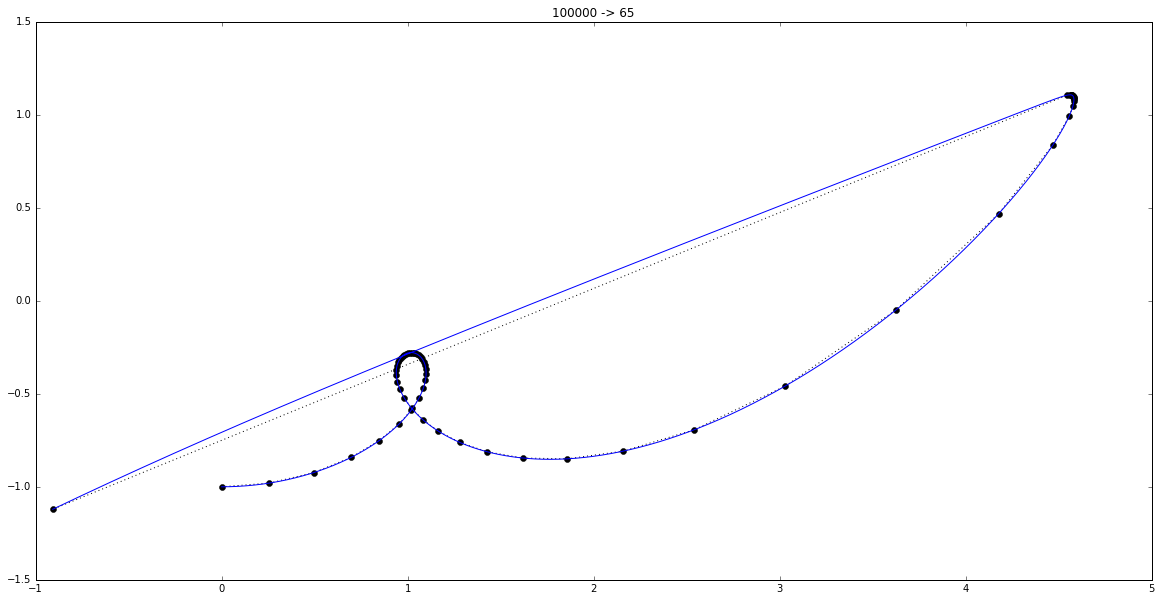

In [9]:
plot_compare(bodyB, fractal_trace)

Darn it, not as good as the max deviation downsampler. We do well in the high curvature regions, but are insensitive on the long stretches. This is because we are using a ratio, and the longer the stretch, the more we can drift. I think the soluton to this may be to have an absolute distance difference threshold in addition to the ratio threshold and make this an OR operation - if the ratio OR the absolute distance threshold are exceeded, take a sample. 

The ratio threshold takes care of the tight curves and the absolute threshold takes care of the gentle curves.

So ...

In [10]:
def fractal_downsampler2(pos, ratio_thresh=1.001, abs_thresh=0.1):
    d = np.diff(pos, axis=0)
    adaptive_pos = [pos[0, :]]
    last_n = 0
    for n in range(1, pos.shape[0]):
        if n == last_n: continue
        line_d = ln.norm(pos[n, :] - pos[last_n, :])
        curve_d = ln.norm(d[last_n:n,:], axis=1).sum()
        if curve_d / line_d  > ratio_thresh or abs(curve_d - line_d) > abs_thresh:
            adaptive_pos.append(pos[n - 1, :])
            last_n = n - 1
    adaptive_pos.append(pos[-1, :])
    return np.vstack(adaptive_pos)


fractal_trace2 = fractal_downsampler2(bodyB.trace, ratio_thresh=1.005, abs_thresh=0.0001)

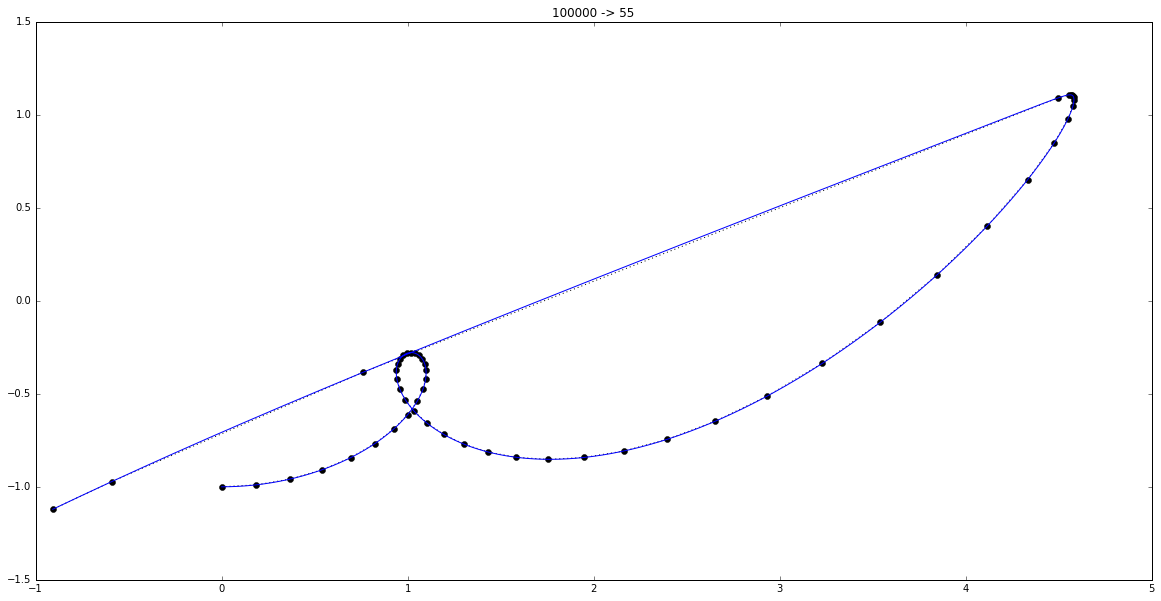

In [11]:
plot_compare(bodyB, fractal_trace2)

This looks like a good downsampling scheme. It's nice to have two knobs to control: one for the tight curves and one for the less curvy stretches. This allows us to get close to the max deviation downsampler without needing a ton of memory